# Implementación 3: Modelo Logistic Regression

## Importación de librerias y creación de funciones

In [1]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score,GridSearchCV,ShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score,roc_auc_score,precision_recall_curve,roc_curve

In [2]:
def cargar_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [3]:
def export_pickle(objeto, ruta_archivo):
    # Verificar si la ruta del directorio existe, si no, crearla
    directorio = os.path.dirname(ruta_archivo)
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    # Guardar el objeto en un archivo pickle en la ruta especificada
    with open(ruta_archivo, 'wb') as archivo:
        pickle.dump(objeto, archivo)
    print(f'Objeto exportado exitosamente a {ruta_archivo}')

In [4]:
df=cargar_csv(os.path.join('..','Data','output','train_data_1.csv'))

## Desarrollo

### Parametrización

En esta sección se busca parametrizar el desarrollo, dividir el conjunto de datos, definir parámetros de entrenamiento y hacer la creación del pipeline para el modelo

In [5]:
independent_var_erase=['7d','15d','60d','zonificacion']
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]

In [6]:
X=df[independent_var]
y=df[dependent_var]

# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Total de columnas
VAR_cols = VAR_categorical_cols + VAR_numerical_cols

print('Variables categoricas: ',VAR_categorical_cols)
print('Variables numericas: ',VAR_numerical_cols)
print('Variables independientes: ',VAR_cols)

Variables categoricas:  ['Nomenclatura_del_Suelo', 'tipo_geologia']
Variables numericas:  ['ELEVACION', 'PENDIENT', '24h', '10d', '30d', '90d']
Variables independientes:  ['Nomenclatura_del_Suelo', 'tipo_geologia', 'ELEVACION', 'PENDIENT', '24h', '10d', '30d', '90d']


Esto nos indica cuales son las variables que usaremos para el entrenamiento y cuales variables eliminamos, adicionalmente guardamos por separados las variables categóricas y las numéricas para su tratamiento

In [7]:
# Crea un diccionario para los codificadores
label_encoders = {}

for feature in VAR_categorical_cols:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

In [8]:
label_encoders

{'Nomenclatura_del_Suelo': LabelEncoder(), 'tipo_geologia': LabelEncoder()}

Creamos los codificadores, usaremos `LabelEncoder()` debido a la cantidad de clases que puede tomar cada variable categórica, optimizando recursos computacionales. 

Este objeto nos servirá para codificar valores nuevos que entren al modelo 

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.5, test_size=0.5,random_state=23)

In [10]:
shuffle_split = ShuffleSplit(test_size=.3, train_size=.7, n_splits=10)

Como se había explicado en la seccion de Contextualización, usaremos [validación cruzada aleatoria y dividida](intro.md#esquema-de-entrenamiento)

In [11]:
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Valores de regularización
    'classifier__solver': ['liblinear', 'saga'],  # Algoritmos de optimización
    'classifier__penalty': ['l2'],  # Regularización L2 para multicolinealidad
}

- C: Controla la fuerza de la regularización. Un valor más pequeño implica una mayor penalización y por tanto, menor susceptibilidad a la multicolinealidad.

- solver: Es el algoritmo utilizado para optimizar el modelo. liblinear es eficiente para conjuntos de datos pequeños, mientras que saga puede manejar conjuntos de datos grandes y dispersos.

- penalty: Seleccionamos l2 para manejar la multicolinealidad.


In [12]:
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

In [13]:
pipeline_lr= Pipeline([
    ('preprocessor',preprocessor_lr),
    ('classifier', LogisticRegression())
])
pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   '24h', '10d', '30d',
                                                   '90d'])])),
                ('classifier', LogisticRegression())])

Esto quiere decir que nuestro pipeline encapsula un proceso en el que las columnas numéricas pasan por un proceso de estandarización antes de pasar al modelo

In [14]:
X_train.head()

,ELEVACION,PENDIENT,Nomenclatura_del_Suelo,tipo_geologia,24h,10d,30d,90d
860,1908.621826,33.349747,20,9,5.0,91.0,182.0,364.0
931,1012.722534,58.263329,25,9,0.0,207.0,566.0,878.0
516,997.682312,10.481087,20,1,0.0,2.0,28.0,204.0
784,1083.413696,39.863770,25,7,13.0,143.0,365.0,642.0
274,1013.982971,37.013683,25,9,0.4,112.0,316.2,530.0


In [15]:
y_train.head()

860    1
931    1
516    0
784    1
274    1
Name: deslizamientos, dtype: int64

Así se ve nuestra data de entrenamiento que pasará por el `Pipeline` que se definió

### Rendimiento en Training y Test

La siguiente celda de código junta todas las piezas que definimos previamente, y entrena el modelo de clasificación. Después imprime un mensaje personalizado con el pipeline definido y la combinación de parámetros ganadora

In [16]:
grid_search = GridSearchCV(pipeline_lr, param_grid_lr, cv=shuffle_split,scoring='precision', return_train_score=True)
grid_search.fit(X_train, y_train)
msg_training=f"LogisticRegressor \n modelo ganador: {grid_search.best_estimator_} \n mejor combinacion de parametros: {grid_search.best_params_}"
print(msg_training)
model_lr=grid_search.best_estimator_

LogisticRegressor 
 modelo ganador: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   '24h', '10d', '30d',
                                                   '90d'])])),
                ('classifier', LogisticRegression(C=100, solver='liblinear'))]) 
 mejor combinacion de parametros: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [17]:
# Resultados del GridSearchCV
results_lr = grid_search.cv_results_
#  Convertir los resultados en un DataFrame para una mejor visualización
df_results = pd.DataFrame(results_lr)

# Mostrar solo las columnas relevantes
df_results = df_results[['rank_test_score','param_classifier__C','param_classifier__solver','param_classifier__penalty', 'mean_train_score', 'mean_test_score']]
df_results=df_results.rename(columns={'param_classifier__C':'C',
                                      'param_classifier__solver':'solver',
                                      'param_classifier__penalty':'penalty',
                                      'mean_train_score':'Rendimiento promedio - Train',
                                      'mean_test_score':'Rendimiento promedio - Test',
                                      'rank_test_score':'Model Ranking'
                                      })
# Ordenar por la mejor puntuación en test
df_sorted = df_results.sort_values(by='Model Ranking', ascending=True)

# Mostrar las primeras 10 filas (los mejores modelos)
df_sorted.head(10)

,Model Ranking,C,solver,penalty,Rendimiento promedio - Train,Rendimiento promedio - Test
10,1,100,liblinear,l2,0.919069,0.901822
8,2,10,liblinear,l2,0.917563,0.901088
6,3,1,liblinear,l2,0.908985,0.894156
9,4,10,saga,l2,0.905530,0.887461
11,4,100,saga,l2,0.906038,0.887461
5,6,0.1,saga,l2,0.904803,0.887363
7,7,1,saga,l2,0.905157,0.885357
4,8,0.1,liblinear,l2,0.898470,0.881932
3,9,0.01,saga,l2,0.866652,0.842488
2,10,0.01,liblinear,l2,0.854739,0.834013


Las métricas de rendimiento en el conjunto de entrenamiento y prueba se calculan durante el proceso de búsqueda de hiperparámetros.

En esta tabla podemos ver el top 10 de los modelos que fueron entrenados con los valores de sus parámetros. Como podemos ver, el modelo ganador, es aquel que tiene el valor de `Model Ranking` como 1. Podemos ver su puntaje en Entrenamiento y en Prueba, vemos que tuvo muy buenos puntajes

### Rendimiento en Validation

In [18]:
y_pred_lr = model_lr.predict(X_valid)
y_pred_proba_lr=model_lr.predict_proba(X_valid)[:, 1]
precision_lr = precision_score(y_valid, y_pred_lr)
accuracy_lr = accuracy_score(y_valid, y_pred_lr)
recall_lr = recall_score(y_valid, y_pred_lr)
f1_lr = f1_score(y_valid, y_pred_lr)

data_reporte_lr = {
    'Modelo': ['Logistic Regressor'],
    'Precision': [precision_lr],
    'Recall': [recall_lr],
    'Exactitud': [accuracy_lr],
    'F1-score': [f1_lr]
}

df_reporte_lr = pd.DataFrame(data_reporte_lr)
df_reporte_lr

,Modelo,Precision,Recall,Exactitud,F1-score
0,Logistic Regressor,0.929688,0.88806,0.898947,0.908397


Al probar el modelo ganador con datos de validación que nunca ha visto, miramos que las métricas se mantienen y son muy buenas

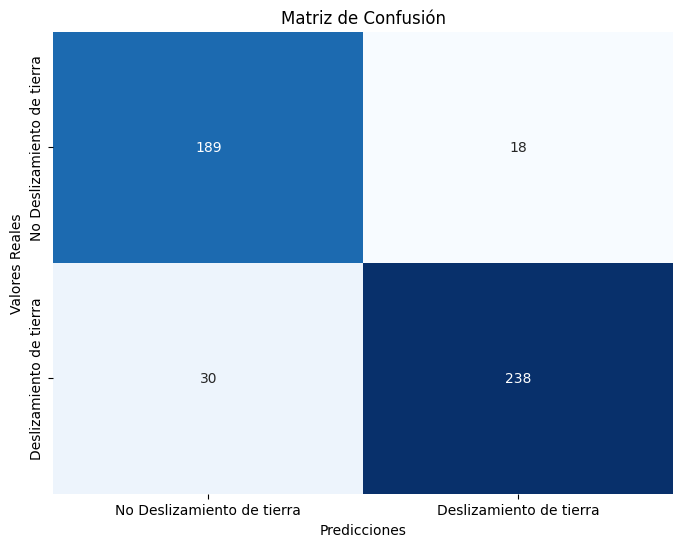

In [19]:
cm = confusion_matrix(y_valid, y_pred_lr)
# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Deslizamiento de tierra', 'Deslizamiento de tierra'], yticklabels=['No Deslizamiento de tierra', 'Deslizamiento de tierra'])

# Añadir etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

Al mirar la matriz de confusión, nos damos cuenta de que el conteo más bajo es cuando el modelo predice que no habrá deslizamientos, pero en realidad si hubo deslizamiento. Este es el índice que precisamente debemos apuntar a minimizar, porque en la realidad del negocio el costo de actuar sobre un falso positivo es alto, es decir se tiene recursos limitados para manejar casos positivos y se quiere minimizar las consecuencias negativas de las predicciones incorrectas de la clase positiva (falsos positivos). 

In [20]:
train_performance=df_sorted[df_sorted['Model Ranking']==1]['Rendimiento promedio - Train'].values.item()
trest_performance=df_sorted[df_sorted['Model Ranking']==1]['Rendimiento promedio - Test'].values.item()
valid_performance=df_reporte_lr['Precision'].values.item()

Como conclusión tenemos un modelo de clasificación Random Forest con estos puntajes de rendimiento para la medida de Precision

In [21]:
print(f'Precision score en training: {train_performance}')
print(f'Precision score en test: {trest_performance}')
print(f'Precision score en validation: {valid_performance}')

Precision score en training: 0.9190689579763422
Precision score en test: 0.9018218081948512
Precision score en validation: 0.9296875


### Explicabilidad del modelo

Veamos el AUC

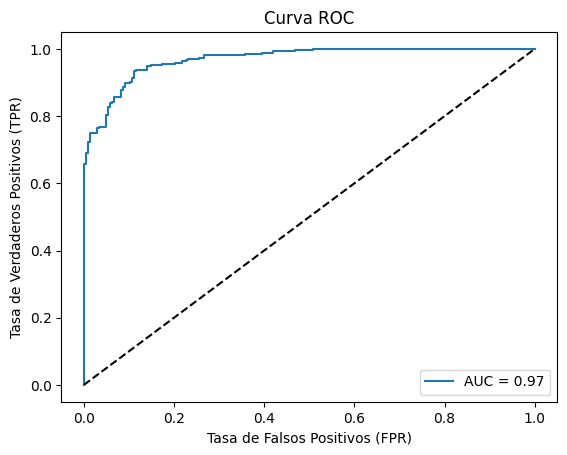

In [22]:
# Calcular valores de la curva ROC
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba_lr)
auc = roc_auc_score(y_valid, y_pred_proba_lr)

# Graficar curva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

Un AUC de 0.96 sugiere que el modelo tiene un rendimiento excelente. En el 96% de los casos, el modelo clasificará correctamente una observación positiva y una negativa.

La curva que se acerca mucho a la esquina superior izquierda también refuerza la idea de que el modelo tiene una alta sensibilidad y es muy bueno en la clasificación correcta de las instancias positivas.

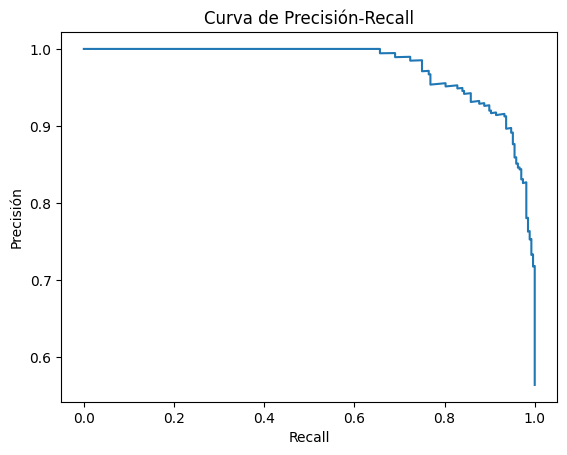

In [23]:
# Calcular precisión y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba_lr)

# Graficar la curva de precisión-recall
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall')
plt.show()

En la parte izquierda de la gráfica (bajos valores de recall), la precisión es muy alta (cerca de 1). Esto indica que cuando el modelo clasifica una instancia como positiva, la probabilidad de que sea correcta es alta, aunque no detecta muchas de las verdaderas instancias positivas (bajo recall). A medida que el recall aumenta, la precisión empieza a disminuir. Esto es común, ya que al aumentar el número de verdaderos positivos identificados (mayor recall), el modelo también puede empezar a identificar más falsos positivos, lo que reduce la precisión.

En la parte derecha (altos valores de recall), la precisión cae drásticamente. Esto ocurre porque el modelo intenta clasificar la mayor cantidad posible de positivos, pero a expensas de incluir falsos positivos, lo que disminuye su precisión.

Esta curva muestra un buen equilibrio entre precisión y recall en la mayor parte del rango, especialmente cuando se busca maximizar la precisión sin sacrificar demasiado el recall. El modelo es bueno capturando positivos sin generar muchos falsos positivos, pero su rendimiento decae cuando intenta maximizar demasiado el recall.

Exportamos el modelo:

In [24]:
# En esta celda exportamos el modelo para usarlo posteriormente

model_object={'modelo':model_lr
              ,'encoder':label_encoders}
nombre_modelo='logistic-regressor-model'
ruta_m=os.path.join('..','Models','output',f'{nombre_modelo}.pkl')

export_pickle(model_object,ruta_m)

Objeto exportado exitosamente a ../Models/output/logistic-regressor-model.pkl
